In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from pathlib import Path
from matplotlib import rcParams, pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
data_dir = Path('./open')
feature_dir = Path('./build/feature')
val_dir = Path('./ensemble/build/val')
tst_dir = Path('./ensemble/build/tst')
sub_dir = Path('./open/sub')
dirs = [feature_dir, val_dir, tst_dir, sub_dir]
for d in dirs:
    os.makedirs(d, exist_ok=True)

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test_x.csv'
sample_file = data_dir / 'sample_submission.csv'
glove_file = './dataset/glove.6B/glove.6B.100d.txt'

target_col = 'author'
n_fold = 5
n_class = 5
seed = 42

In [3]:
algo_name = 'cnn'
feature_name = 'glove'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [4]:
embeddings_index = {}
with open(glove_file, encoding = 'UTF8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
        
print(f'Found {len(embeddings_index)} word vectors.')

Found 400001 word vectors.


<h2> 학습데이터 로드

In [5]:
train = pd.read_csv(trn_file, index_col=0)
train.head()

,text,author
index,,
0,"He was almost choking. There was so much, so m...",3
1,"“Your sister asked for it, I suppose?”",2
2,"She was engaged one day as she walked, in per...",1
3,"The captain was in the porch, keeping himself ...",4
4,"“Have mercy, gentlemen!” odin flung up his han...",3


In [6]:
test = pd.read_csv(tst_file, index_col=0)
test.head()

,text
index,
0,“Not at all. I think she is one of the most ch...
1,"""No,"" replied he, with sudden consciousness, ""..."
2,As the lady had stated her intention of scream...
3,“And then suddenly in the silence I heard a so...
4,His conviction remained unchanged. So far as I...


<h2> Preprocessing

In [7]:
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)


def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)


stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "odin",
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [8]:
train['text'] = train['text'].str.lower().apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].str.lower().apply(alpha_num).apply(remove_stopwords)

In [10]:
train['length'] = train['text'].apply(len)

In [12]:
idx_under_20 = train[train['length'] < 20].index
train = train.drop(idx_under_20)
train = train.reset_index()
train.describe()

,level_0,index,author,length
count,49420.000000,49420.000000,49420.000000,49420.00000
mean,24709.500000,27442.838062,1.940004,143.06467
std,14266.469489,15852.437381,1.403680,165.90232
min,0.000000,0.000000,0.000000,20.00000
25%,12354.750000,13715.750000,1.000000,42.00000
50%,24709.500000,27403.500000,2.000000,75.00000
75%,37064.250000,41203.250000,3.000000,169.00000
max,49419.000000,54878.000000,4.000000,1387.00000


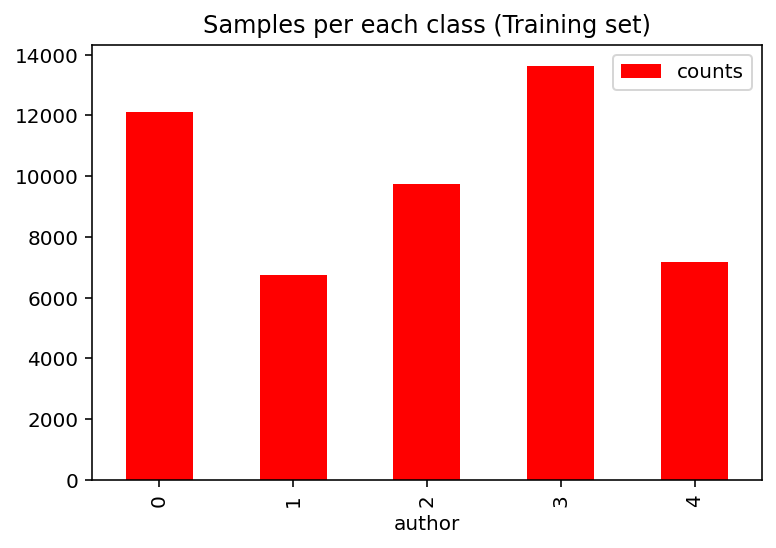

In [13]:
train.groupby(train.author).size().reset_index(name="counts").plot.bar(x='author',title="Samples per each class (Training set)",color='red')


In [14]:
trn = train['text'].values
tst = test['text'].values
y = train['author'].values
print(trn.shape, tst.shape, y.shape)

(49420,) (19617,) (49420,)


In [15]:
from sklearn.model_selection import train_test_split
SEED = 200
X_trn, X_val, y_trn, y_val = train_test_split(train.text, train.author, test_size=0.2, random_state=3,stratify= train.author)

In [16]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=500000)
tokenizer.fit_on_texts(X_trn)
sequences_train = tokenizer.texts_to_sequences(X_trn)
sequences_validation = tokenizer.texts_to_sequences(X_val)

In [17]:
max_length = 150
from keras.preprocessing import sequence
x_train=sequence.pad_sequences(sequences_train,maxlen=max_length)
x_validation=sequence.pad_sequences(sequences_validation,maxlen=max_length)
print(f"Train set shape: {x_train.shape}\nValidation set shape: {x_validation.shape}")

Train set shape: (39536, 150)
Validation set shape: (9884, 150)


In [18]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
y_train_categorical=encoder.fit_transform(y_trn.values.reshape(-1, 1))
y_validation_categorical=encoder.transform(y_val.values.reshape(-1, 1))

In [19]:
print(f"Train set labels: {y_train_categorical.__len__()}\nValidation set labels: {y_validation_categorical.__len__()}")


Train set labels: 39536
Validation set labels: 9884


<h2> 모델

In [20]:
from keras.layers import *
from keras import regularizers
from keras import Sequential,optimizers
from keras_sequential_ascii import keras2ascii

class CNNtext(Sequential):
    """
    This class extends  keras.sequencial in order to build our 
    model according to the designed architecture
    """
    #params for the convolutional layers
    __num_filters = 64
    __weight_decay = 1e-4
    #optimizers
    __adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    def __init__(self,max_length,number_of_classes,embedding_matrix=None,vocab_size=None,tokenizer=None):
        #creating the model heritance from Keras.sequencial
        super().__init__()
        #params for the embedding layer
        self.__embedding_dim=100 if embedding_matrix is None else embedding_matrix.shape[1]
        #self.__vocab_size=vocab_size if tokenizer is None else tokenizer.word_index.__len__()+1
        self.__vocab_size=vocab_size if tokenizer is None else max(tokenizer.index_word.keys())+1
        try:
            self.__max_length=max_length
            self.__number_of_classes=number_of_classes 
        except NameError as error:
            print("Error ",error," must be defined.")
            
        #defining layers
        #This layer will learn an embedding the vocab_size is the vocabulary learn from our tokenizer
        #the embedding dimension is defined by our selfs in this case we choose a dimension of 100
        #the input length is the maximum length of the documents we will use
        if embedding_matrix is None:
            self.add(Embedding(self.__vocab_size,
                               self.__embedding_dim,
                               input_length=self.__max_length,trainable=True))
        else:
            self.add(Embedding(embedding_matrix.shape[0],
                               embedding_matrix.shape[1],
                               weights=[embedding_matrix],
                               input_length=self.__max_length,
                               trainable=False))
        #then we apply a 1D conv layer that should apply filters to the sequence and generate features maps.
        self.add(Conv1D(self.__num_filters, 7, activation='relu', padding='same'))
        #then we will get the most important features using a max pooling layer
        self.add(MaxPooling1D(2))
        #afterwards we apply a conv 1D layer to learn new features form the previous results
        self.add(Conv1D(self.__num_filters, 7, activation='relu', padding='same'))
        #we select again the most important features
        self.add(GlobalMaxPooling1D())
        #then we apply dropout to improve the generalization
        self.add(Dropout(0.5))
        #then we will pass the results into a dense layer that will also learn some internal representation and we also use the l2 regularization
        self.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(self.__weight_decay)))
        #for the final layer we will use softmax to obtain the probabilities of each class.
        self.add(Dense(self.__number_of_classes, activation='softmax'))  
        #to compute the loss function we use binary_crossentropy
        #which is widely used for multi-classification problems
        #we also use the adam optimazer to learn the parameters(weights)
        #and minimize the loss function.
        # 몰랐는데 binary_crossentropy가 multi-classification 에 좋다고 하는군요.
        # binary_crossentropy는 반드시 binary-classification에만 써야 하는건줄 알았는데...
        self.compile(loss='binary_crossentropy', optimizer=self.__adam, metrics=['accuracy'])

In [21]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2, verbose=1)

In [22]:
#training params
batch_size = 64
num_epochs = 10

In [23]:
tokenizer.num_words

500000

In [24]:
max_length=150

In [25]:
CNN_BOW=CNNtext(max_length,
              encoder.classes_.__len__(),
              tokenizer=tokenizer)

In [26]:
keras2ascii(CNN_BOW)


           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####         150
           Embedding   emb | -------------------   4221900    98.2%
                       #####    150  100
              Conv1D    \|/  -------------------     44864     1.0%
                relu   #####    150   64
        MaxPooling1D   Y max -------------------         0     0.0%
                       #####     75   64
              Conv1D    \|/  -------------------     28736     0.7%
                relu   #####     75   64
  GlobalMaxPooling1D   Y^max -------------------         0     0.0%
                       #####          64
             Dropout    | || -------------------         0     0.0%
                       #####          64
               Dense   XXXXX -------------------      2080     0.0%
                relu   #####          32
               Dense   XXXXX -------------------       165     0.0%
             softmax   #####           5


In [27]:
x_train.shape, y_train_categorical.shape, x_validation.shape, y_validation_categorical.shape

((39536, 150), (39536, 5), (9884, 150), (9884, 5))

In [28]:
hist = CNN_BOW.fit(x_train, y_train_categorical,
                 batch_size=batch_size, epochs=num_epochs, callbacks=[es],
                 validation_data=(x_validation,y_validation_categorical),
                 shuffle=True)

Epoch 1/10
618/618 [==============================] - 44s 71ms/step - loss: 0.3792 - accuracy: 0.5102 - val_loss: 0.2858 - val_accuracy: 0.6545
Epoch 2/10
618/618 [==============================] - 45s 72ms/step - loss: 0.2314 - accuracy: 0.7480 - val_loss: 0.2528 - val_accuracy: 0.7246
Epoch 3/10
618/618 [==============================] - 45s 74ms/step - loss: 0.1516 - accuracy: 0.8464 - val_loss: 0.2674 - val_accuracy: 0.7339
Epoch 4/10
618/618 [==============================] - 46s 74ms/step - loss: 0.1086 - accuracy: 0.8933 - val_loss: 0.2884 - val_accuracy: 0.7344
Epoch 00004: early stopping


In [29]:
def plot_model_perfomance(hist,name):
    plt.style.use('fivethirtyeight')
    plt.figure(1)
    plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
    plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend(loc='upper right')
    plt.figure(2)
    plt.plot(hist.history['accuracy'], lw=2.0, color='b', label='train')
    plt.plot(hist.history['val_accuracy'], lw=2.0, color='r', label='val')
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.show()

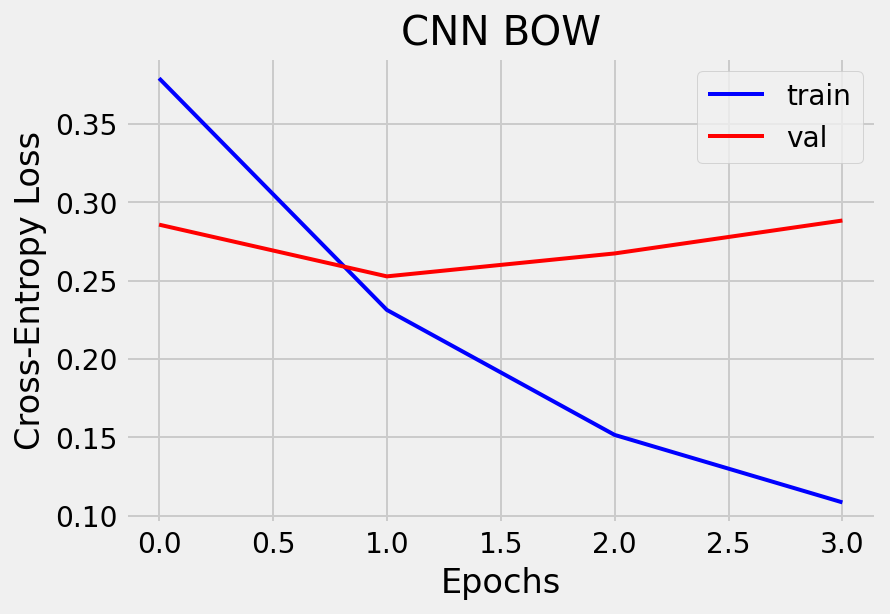

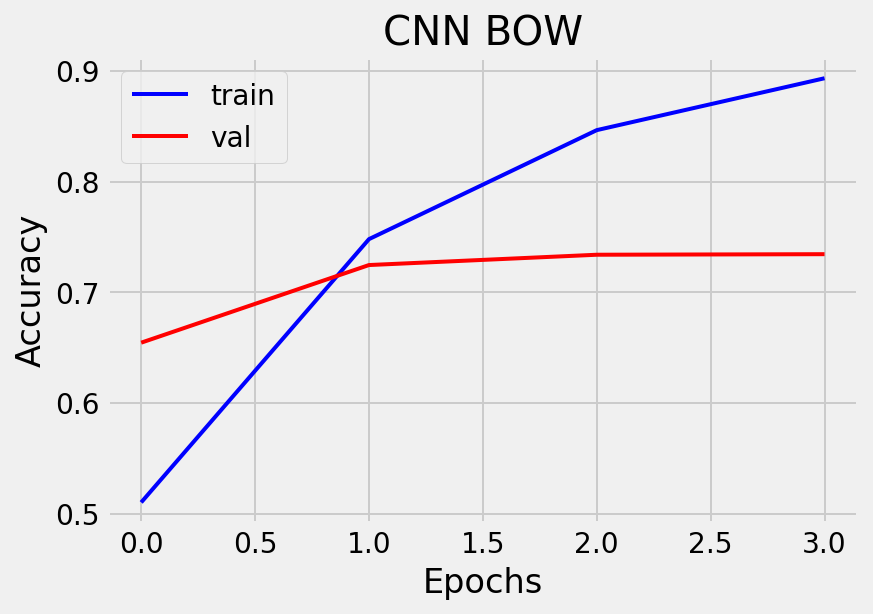

In [30]:
plot_model_perfomance(hist,'CNN BOW')


In [31]:
bow_predict_y_validation = CNN_BOW.predict(x_validation,verbose=1)


309/309 [==============================] - 1s 3ms/step


In [32]:
bow_predict_y_validation= encoder.inverse_transform(bow_predict_y_validation)


In [33]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y=None,y_predict=None,classes=None,name=None):
    plt.figure(figsize=(30, 30))
    sns.heatmap(confusion_matrix(y,y_predict), 
                xticklabels=classes,
                yticklabels=classes)
    plt.title(name)
    plt.show()

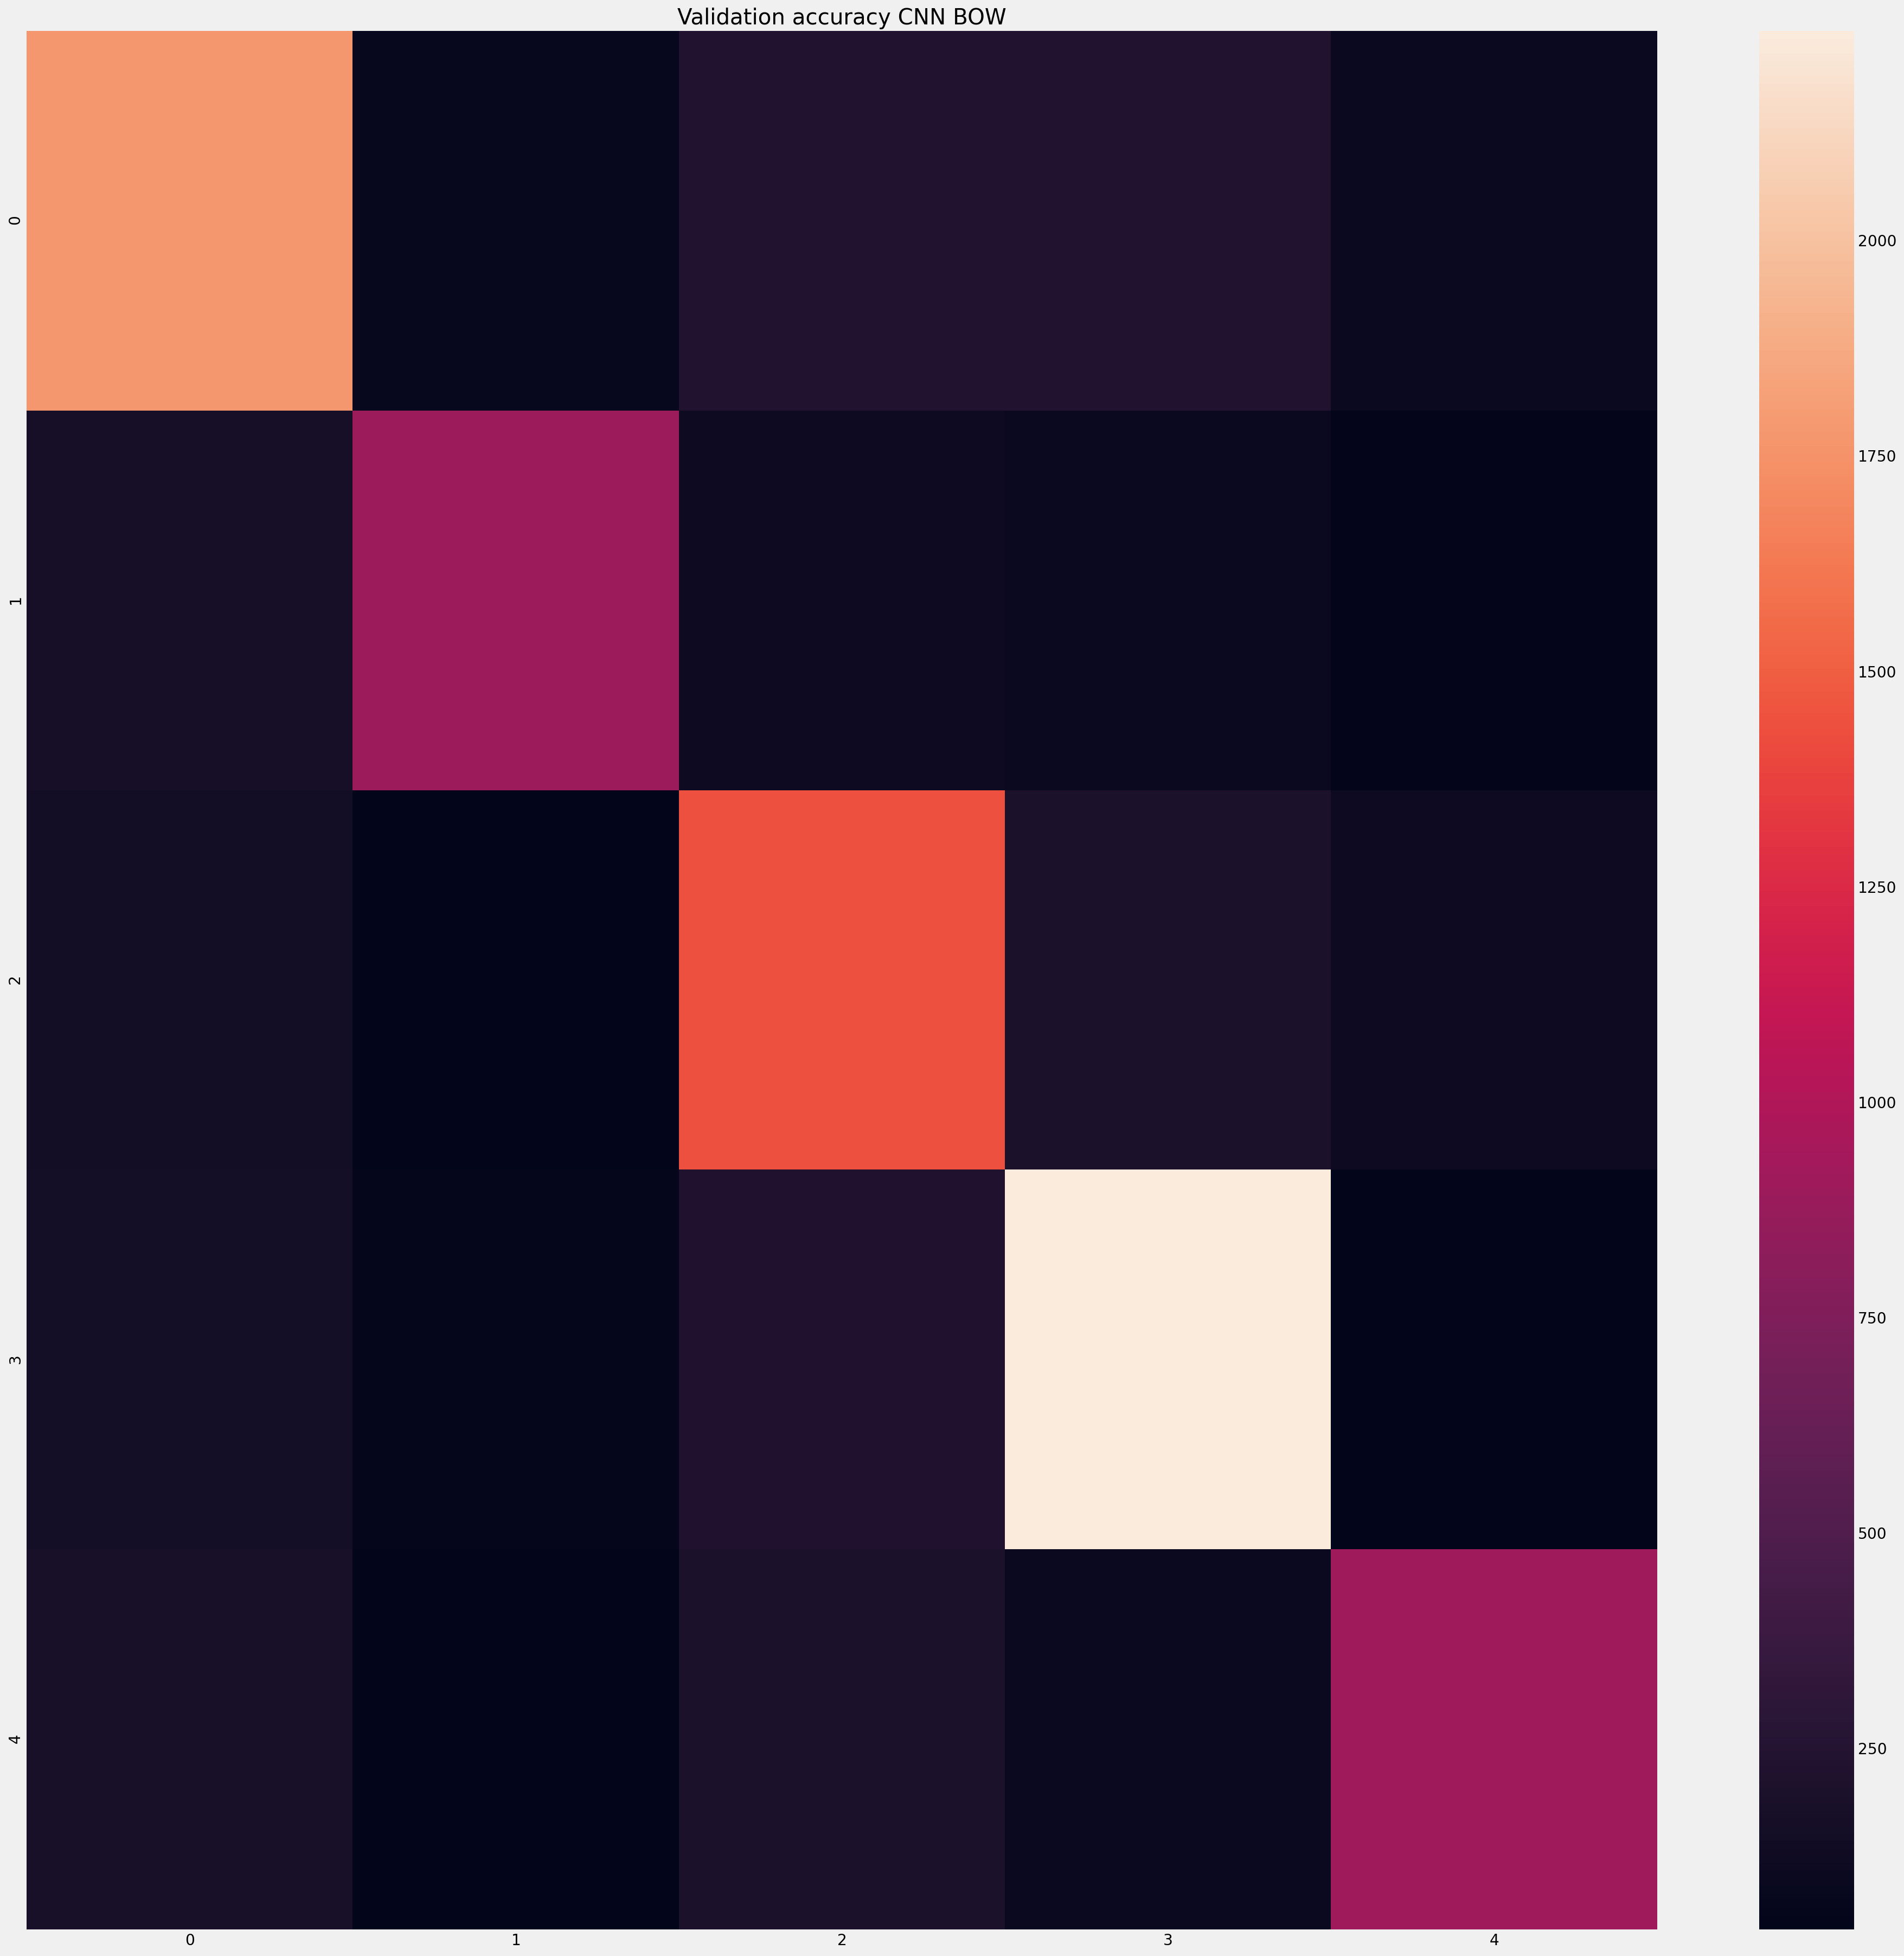

In [34]:
plot_confusion_matrix(y_val,bow_predict_y_validation,encoder.classes_,'Validation accuracy CNN BOW')


In [35]:
sequences_test = tokenizer.texts_to_sequences(tst)
tst=sequence.pad_sequences(sequences_test,maxlen=max_length)

pred = CNN_BOW.predict(tst)

In [36]:
pred

array([[4.8191547e-03, 3.7957120e-01, 2.9766840e-01, 2.9897264e-01,
        1.8968588e-02],
       [2.5684096e-02, 7.5664324e-01, 1.9849809e-02, 1.3449863e-02,
        1.8437293e-01],
       [9.9999201e-01, 4.3030423e-06, 2.2529200e-07, 2.1010370e-08,
        3.4809104e-06],
       ...,
       [1.4035286e-05, 9.9998367e-01, 1.3904364e-07, 1.9042740e-06,
        2.8042729e-07],
       [5.7766899e-03, 9.9258280e-01, 4.0050305e-04, 6.0800393e-04,
        6.3208176e-04],
       [9.9995792e-01, 3.1552736e-06, 1.6069428e-06, 1.5407917e-08,
        3.7483722e-05]], dtype=float32)

In [37]:
# submission
sample_submission = pd.read_csv('open/sample_submission.csv', encoding = 'utf-8')
sample_submission[['0','1','2','3','4']] = pred
sample_submission

sample_submission.to_csv('open/sub/submission_CNN_shared.csv', index = False, encoding = 'utf-8')
